In [1]:
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import gc
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
import json

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
entprise_train = pd.read_csv('../train/entprise_info.csv',engine='python')
base_info = pd.read_csv('../train/base_info.csv',engine='python',encoding='utf-8')
entprise_test = pd.read_csv('../entprise_evaluate.csv')
reccap_predict = pd.read_csv('../reccap_predict.csv')['reccap']
empnum_predict = pd.read_csv('../empnum_predict.csv')['empnum']

In [3]:
entprise = pd.concat([entprise_train,entprise_test])
data = pd.merge(entprise,base_info,on='id')
data.drop(['ptbusscope','midpreindcode','score'],axis=1,inplace=True)

In [4]:
data['enttypeitem'] = data['enttypegb']//10*10
data['enttypeminu'] = data['enttypegb']

In [5]:
data['regcap'] = data['regcap'].fillna(data['regcap'].mean())
data['reccap'] = reccap_predict
data['empnum'] = empnum_predict
data['reccap'] = data['reccap']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24865 entries, 0 to 24864
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             24865 non-null  object 
 1   label          14865 non-null  float64
 2   oplocdistrict  24865 non-null  int64  
 3   industryphy    24865 non-null  object 
 4   industryco     24864 non-null  float64
 5   dom            24865 non-null  object 
 6   opscope        24865 non-null  object 
 7   enttype        24865 non-null  int64  
 8   enttypeitem    24865 non-null  int64  
 9   opfrom         24865 non-null  object 
 10  opto           8825 non-null   object 
 11  state          24865 non-null  int64  
 12  orgid          24865 non-null  int64  
 13  jobid          24865 non-null  int64  
 14  adbusign       24865 non-null  int64  
 15  townsign       24865 non-null  int64  
 16  regtype        24865 non-null  int64  
 17  empnum         24865 non-null  float64
 18  compfo

In [7]:
data['opform'].fillna(10,inplace=True)
data['opform'] = data['opform'].astype(str)

In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder1 = LabelEncoder()
labelencoder2 = LabelEncoder()
labelencoder3 = LabelEncoder()
labelencoder4 = LabelEncoder()
data['opform'] = labelencoder1.fit_transform(data['opform'])
data['oploc'] = labelencoder2.fit_transform(data['oploc'])
data['industryphy'] = labelencoder3.fit_transform(data['industryphy'])
data['oplocdistrict'] = labelencoder4.fit_transform(data['oplocdistrict'])

In [9]:
def opto_process(x):
    if len(x)>3:
        return x[:4]
    else:
        return x
data['opfrom'] = data['opfrom'].map(lambda x:x[:4])
data['opto'].fillna('nan',inplace=True)
data['opto'] = data['opto'].map(opto_process)
data['opfrom'] = data['opfrom'].astype(int)
data['opto'] = data['opto'].astype(float)

In [10]:
data['industryco'] = data['industryco'].fillna(data['industryco'].mean())

In [11]:
data.loc[data['opto'].isnull(),"opto"] = data[data['opto'].isnull()]['opfrom']+50.0

In [12]:
data['enttpe_year'] = data['opfrom'] - data['opto']

In [13]:
data['opscope'] = data['opscope'].apply(lambda x:x.replace("、","/").replace("；","/").replace("，","/").replace("。","/"))
data['opscope'] = data['opscope'].apply(lambda x:x.replace("（","/").replace("）","/").replace("，","/").replace("。","/"))

In [14]:
data['opscope'] = data['opscope'].apply(lambda x:"".join(x.split("/")))

In [15]:
data['opscope']

0        实业投资创业投资投资咨询不得从事经纪涉及前置许可的除外依法须经批准的项目经相关部门批准后方可...
1                                           摄影摄像相册冲印制作司仪服务
2        OLED显示屏制造LED电子屏销售发光二极管LED芯片制造设备制造发光二极管LED管制造标牌...
3        新能源科技领域内的技术研发技术服务金属材料除贵金属煤炭铁精粉矿产品钢材化工产品除危化品建筑材...
4                        汽车维修保养服务依法须经批准的项目经相关部门批准后方可开展经营活动
                               ...                        
24860    化妆品日用百货一类医疗器械婴幼儿用品服装服饰销售健康信息咨询除医疗广告设计制作发布代理投资管...
24861    生物技术咨询研发转让保健食品批发食品流通许可证有效期至2017年8月3日化妆品高分子材料电器...
24862    环保领域内的技术开发技术咨询技术服务技术转让环保设备的设计生产销售镁合金铝合金及其它金属国家...
24863    电子产品电子元器件线束电子连接器五金电线电缆研发生产销售自营和代理各类商品和技术的进出口业务...
24864    资产管理投资管理投资咨询证券期货咨询除外财务咨询企业管理咨询以上咨询均除经纪市场信息咨询企业...
Name: opscope, Length: 24865, dtype: object

In [16]:
import jieba
data['opscope_1'] = data['opscope'].apply(lambda x:jieba.lcut(x,cut_all=True))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.566 seconds.
Prefix dict has been built successfully.


In [17]:
from collections import Counter
def jieba_func(x):
    str1 = list(Counter(x).keys())[0]
    str2 = list(Counter(x).keys())[1]
    count = str1+str2
    return count
data['count_opscope'] = data['opscope'].apply(lambda x:jieba_func(x))

In [18]:
le6 = LabelEncoder()
data['opscope_length'] = data['opscope_1'].apply(lambda x:len(x))
# data['opscope'] = data['opscope'].apply(lambda x:x.split('/')[-2:])
data['opscope_label'] = le6.fit_transform(data['count_opscope'])

In [19]:
def bucket(name,bucket_len):
    gap_list=[data[name].quantile(i/bucket_len) for i in range(bucket_len+1)]
    len_data=len(data[name])
    new_col=[]
    for i in data[name].values:
        for j in range(len(gap_list)):
            if gap_list[j]>=i:
                encode=j
                break
        new_col.append(encode)
    return new_col
#注册资本_实缴资本
data['regcap_reccap']=data['regcap']-data['reccap']
#注册资本分桶
data['regcap']=data['regcap'].fillna(data['regcap'].median())
data['bucket_regcap']=bucket('regcap',5)
#实缴资本分桶
data['reccap']=data['reccap'].fillna(data['reccap'].median())
data['bucket_reccap']=bucket('reccap',5)
#注册资本_实缴资本分桶
data['regcap_reccap']=data['regcap_reccap'].fillna(data['regcap_reccap'].median())
data['bucket_regcap_reccap']=bucket('regcap_reccap',5)
print('分桶完毕.................')

分桶完毕.................


In [20]:
# data['dom'] = data['dom'].apply(lambda x:x[:16])
le7 = LabelEncoder()
data['dom'] = le7.fit_transform(data['dom'])

In [21]:
# data['dom_1'] = data['dom'].apply(lambda x:x[:16])
# data['dom_2'] = data['dom'].apply(lambda x:x[16:32])
# data['dom_3'] = data['dom'].apply(lambda x:x[32:48])
# data['dom_4'] = data['dom'].apply(lambda x:x[48:64])
# data['dom_5'] = data['dom'].apply(lambda x:x[64:80])
# data['dom_6'] = data['dom'].apply(lambda x:x[80:])
# from sklearn.preprocessing import LabelEncoder
# features_name = [i for i in data.columns if i in ["dom","dom_1","dom_2","dom_3","dom_4","dom_5","dom_6"]]
# for i in features_name:
#     le = LabelEncoder()
#     data[i+'_label'] = le.fit_transform(data[i])
# #data['finall_label'] = data['dom_1_label']+data['dom_2_label']+data['dom_3_label']+data['dom_4_label']+data['dom_5_label']+data['dom_6_label']

In [22]:
data['dom']

0        20778
1        17164
2         6889
3         8423
4         3372
         ...  
24860    21920
24861    12389
24862      568
24863    11310
24864    19326
Name: dom, Length: 24865, dtype: int64

In [23]:
from tqdm import tqdm
def cross_two(name_1,name_2):
    new_col=[]
    encode=0
    dic={}
    val_1=data[name_1]
    val_2=data[name_2]
    for i in tqdm(range(len(val_1))):
        tmp=str(val_1[i])+'_'+str(val_2[i])
        if tmp in dic:
            new_col.append(dic[tmp])
        else:
            dic[tmp]=encode
            new_col.append(encode)
            encode+=1
    return new_col
#作企业类型-小类的交叉特征
data['enttypegb']=data['enttypegb'].fillna("无")
data['enttypeitem']=data['enttypeitem'].fillna("无")
new_col=cross_two('enttypegb','enttypeitem')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem']=new_col
#
#行业类别-细类的交叉特征
data['industryphy']=data['industryphy'].fillna("无")
data['industryco']=data['industryco'].fillna("无")
new_col=cross_two('industryphy','industryco')#作企业类型-小类的交叉特征
data['industryphy_industryco']=new_col
#企业类型-行业类别的交叉特征
new_col=cross_two('enttypegb','industryphy')#作企业类型-小类的交叉特征
data['enttypegb_industryphy']=new_col
#行业类别-企业类型小类的交叉特征
new_col=cross_two('industryphy','enttypeitem')#作企业类型-小类的交叉特征
data['industryphy_enttypeitem']=new_col
#行业类别细类--企业类型小类的交叉特征
new_col=cross_two('industryco','enttypeitem')#作企业类型-小类的交叉特征
data['industryco_enttypeitem']=new_col
new_col=cross_two('enttype','enttypegb_enttypeitem')#作企业类型-小类的交叉特征
data['enttype_enttypegb_enttypeitem']=new_col
#企业类型-小类-行业类别-细类的交叉特征
new_col=cross_two('enttypegb_enttypeitem','industryphy_industryco')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem_industryphy_industryco']=new_col

100%|████████████████████████████████████████████████████████████████████████| 24865/24865 [00:00<00:00, 131441.37it/s]


In [24]:
data['enttypeminu_RANK'] = data['enttypeminu'].map(data.groupby(['enttypeminu'])['label'].mean().rank())
data['enttypeitem_RANK'] = data['enttypeitem'].map(data.groupby(['enttypeitem'])['label'].mean().rank())
data['enttype_RANK'] = data['enttype'].map(data.groupby(['enttype'])['label'].mean().rank())

In [25]:
for fea in ['industryphy','enttype','enttypeitem','opfrom','regcap','opto','enttypeminu']:
    data[fea+'_counts'] = data.groupby([fea])['id'].transform('count')

In [26]:
x_train = data[data['label'].notnull()]
y_train = x_train['label']
x_test = data[data['label'].isnull()]
features_name = [i for i in data.columns if i not in ['id','regcap','reccap','enttype','enttypeitem','enttypeminu','bucket_regcap_reccap','townsign','count_opscope','opscope_1','oplocdistrict','adbusign','compform','opform','orgid','exenum','opscope','enttypegb','label','state','jobid','regtype','parnum','venind','protype','oploc','forreccap','forregcap','congro']]
#features_name = ['industryco', 'dom', 'opfrom', 'opto', 'empnum', 'enttpe_year', 'opscope_length', 'opscope_label', 'regcap_reccap', 'bucket_regcap', 'bucket_reccap', 'enttypegb_enttypeitem', 'industryphy_industryco', 'enttypegb_industryphy', 'industryphy_enttypeitem', 'industryco_enttypeitem', 'enttypegb_enttypeitem_industryphy_industryco', 'industryphy_counts', 'enttype_counts', 'enttypeitem_counts', 'empnum_counts', 'regcap_counts', 'opto_counts']
x_train = x_train[features_name]
x_test = x_test[features_name]

In [27]:
x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)

In [28]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14865 to 24864
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   industryphy                                   10000 non-null  int64  
 1   industryco                                    10000 non-null  float64
 2   dom                                           10000 non-null  int64  
 3   opfrom                                        10000 non-null  int32  
 4   opto                                          10000 non-null  float64
 5   empnum                                        10000 non-null  float64
 6   enttpe_year                                   10000 non-null  float64
 7   opscope_length                                10000 non-null  int64  
 8   opscope_label                                 10000 non-null  int64  
 9   regcap_reccap                                 10000 non-n

In [ ]:
from itertools import combinations

def combine(temp_list, n):
    temp_list2 = []
    for c in combinations(temp_list, n):
        temp_list2.append(list(c))
    return temp_list2

list1 = x_train.columns.values
end_list = []
for i in range(24,len(list1)+1):
    end_list.extend(combine(list1, i))

In [ ]:
print(len(end_list))

## 随机森林

In [29]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
# 模型
rf = RandomForestClassifier(oob_score=True, random_state=2020,
            n_estimators= 60,max_depth=13,min_samples_split=10)
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
def score_fuc(p,r):
    return 2*p*r/(p+r)
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    rf.fit(tf, tt)
    pre_train = rf.predict(tf)
    stat_pre_train = stat_func(pre_train)
    p = precision_score(tt,stat_pre_train)
    r = recall_score(tt,stat_pre_train)
    score = score_fuc(p,r)
    #score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = rf.predict(df)
    stat_pre = stat_func(pre)
    p = precision_score(dt,stat_pre)
    r = recall_score(dt,stat_pre)
    score = score_fuc(p,r)
    devscore.append(score)
    print("Valid F1：%s"%score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

************************************ 1 ************************************
train F1：0.928391959798995
Valid F1：0.8439897698209717
************************************ 2 ************************************
train F1：0.929951690821256
Valid F1：0.8259587020648967
************************************ 3 ************************************
train F1：0.9267982176957351
Valid F1：0.8644859813084111
************************************ 4 ************************************
train F1：0.922879177377892
Valid F1：0.8771084337349399
************************************ 5 ************************************
train F1：0.9241645244215939
Valid F1：0.8416075650118202
Train average F1：0.9264371140230944 Valid average F1：0.8506300903882078


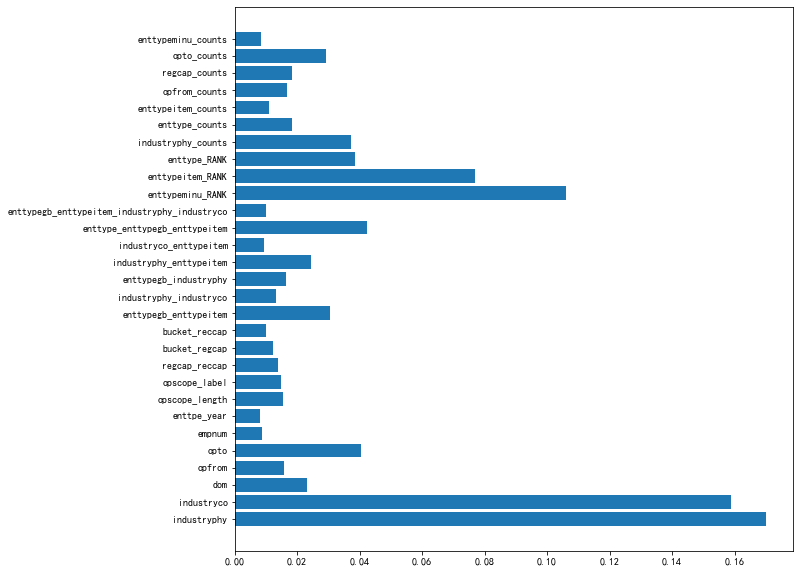

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
a = pd.DataFrame()
feature_import = rf.feature_importances_
feature_name  = x_train.columns.tolist()
plt.barh(feature_name,feature_import)
plt.show()

In [31]:
entprise_test = pd.read_csv('../entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.score.value_counts()

0    9097
1     903
Name: score, dtype: int64

In [ ]:
entprise_test = pd.read_csv('../entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'../result/1130_3.csv', index=False)

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
# 模型
def model_func(x_train_a,y_train_a):
    rf = RandomForestClassifier(oob_score=True, random_state=2020,
                n_estimators= 60,max_depth=13,min_samples_split=10)
    def stat_func(x):
        l1 = []
        for i in x:
            if i>0.5:
                a = 1
                l1.append(a)
            else:
                a = 0
                l1.append(a)
        return l1
    def score_fuc(p,r):
        return 2*p*r/(p+r)
    cat_list = [3]
    # 本地验证
    kf = KFold(n_splits=5,shuffle=True,random_state=2020)
    devscore = []
    tevscore = []
    count = 1
#     result_test = pd.DataFrame()
    for tidx,didx in kf.split(x_train_a.index):
        #print('************************************ {} ************************************'.format(str(count)))
        count += 1
        tf = x_train_a.iloc[tidx]
        df = x_train_a.iloc[didx]
        tt = y_train_a.iloc[tidx]
        dt = y_train_a.iloc[didx]
        rf.fit(tf, tt)
        pre_train = rf.predict(tf)
        stat_pre_train = stat_func(pre_train)
        p = precision_score(tt,stat_pre_train)
        r = recall_score(tt,stat_pre_train)
        score = score_fuc(p,r)
        #score = f1_score(stat_pre_train,tt)
        tevscore.append(score)
        print("train F1：%s"%score)
        pre = rf.predict(df)
        stat_pre = stat_func(pre)
        p = precision_score(dt,stat_pre)
        r = recall_score(dt,stat_pre)
        score = score_fuc(p,r)
        devscore.append(score)
        print("Valid F1：%s"%score)
        result_test[str(count-1)+"折"] = rf.predict(x_test)/5
    print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
    return np.mean(devscore)

In [ ]:
import

In [ ]:
best = 0
best_dic = {}
for n in end_list:
    features_name = n
    x_train_a = x_train[features_name]
    x_test_a = x_test[features_name]
    f1_score = model_func(x_train_a,y_train)
    if f1_score>best:
        best = f1_score
        best_dic[best] = n
        print(n)

In [ ]:
l = ['industryco', 'dom', 'opfrom', 'opto', 'empnum', 'enttpe_year', 'opscope_length', 'opscope_label', 'regcap_reccap', 'bucket_regcap', 'bucket_reccap', 'enttypegb_enttypeitem', 'industryphy_industryco', 'enttypegb_industryphy', 'industryphy_enttypeitem', 'industryco_enttypeitem', 'enttypegb_enttypeitem_industryphy_industryco', 'industryphy_counts', 'enttype_counts', 'enttypeitem_counts', 'empnum_counts', 'regcap_counts', 'opto_counts']
len(l)
#0.8514893338633541

In [ ]:
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']

In [ ]:
result = result_test['result'].values
result_1 = stat_func(result)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
a = pd.DataFrame()
feature_import = rf.feature_importances_
feature_name  = x_train.columns.tolist()
plt.barh(feature_name,feature_import)
plt.show()

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'1115_1.csv', index=False)

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score
from sklearn.model_selection import StratifiedKFold, KFold
#from catboost import CatBoostRegressor
import lightgbm as lgb
# 模型
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=100,
                              learning_rate=0.2, n_estimators=60, max_depth=5, 
                              metric='rmse', bagging_fraction = 1.0, feature_fraction = 1.0)
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    lgb_train = lgb.Dataset(tf,tt,free_raw_data=False)
    lgb_eval = lgb.Dataset(df,dt,reference=lgb_train,free_raw_data=False)
    model_lgb.fit(tf,tt)
    #catr.fit(tf, tt,cat_features=cat_list)
    pre_train = model_lgb.predict(tf)
    stat_pre_train = stat_func(pre_train)
    score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = model_lgb.predict(df)
    stat_pre = stat_func(pre)
    score = f1_score(stat_pre,dt)
    devscore.append(score)
    print("Valid F1：%s"%score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

In [ ]:
entprise_test = pd.read_csv('../entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.score.value_counts()

In [ ]:
entprise_test = pd.read_csv('../entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'../result/1120_2_lgb.csv', index=False)

## Catboost

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
# 模型
def makecatr():
    params = {
        "learning_rate":0.01,
        'iterations':5000,
        'depth': 5,
        'l2_leaf_reg': 3,
        'bootstrap_type':'Bernoulli',
        'od_type': 'Iter',
        'od_wait': 50,
        'random_seed': 2020,
        'allow_writing_files': False,
        'task_type':'CPU',
        'verbose':500,
        'loss_function':'RMSE',
    }
    
    catr = CatBoostRegressor(**params)
    return catr
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
def score_fuc(p,r):
    return 2*p*r/(p+r)
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    catr = makecatr()
    catr.fit(tf, tt,cat_features=cat_list)
    pre_train = catr.predict(tf)
    stat_pre_train = stat_func(pre_train)
    p = precision_score(tt,stat_pre_train)
    r = recall_score(tt,stat_pre_train)
    score = score_fuc(p,r)
    #score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = catr.predict(df)
    stat_pre = stat_func(pre)
    p = precision_score(dt,stat_pre)
    r = recall_score(dt,stat_pre)
    score = score_fuc(p,r)
    devscore.append(score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

In [ ]:
result_1

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'1115_2.csv', index=False)

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score
from sklearn.model_selection import StratifiedKFold, KFold
#from catboost import CatBoostRegressor
import lightgbm as lgb
# 模型
params = {
        'boosting_type': 'gbdt',
        'boosting': 'dart',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.01,
        'num_leaves':25,
        'max_depth':3,
        'max_bin':10,
        'min_data_in_leaf':8,
        'feature_fraction': 0.6,
        'bagging_fraction': 1,
        'bagging_freq':0,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'min_split_gain': 0
}
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    lgb_train = lgb.Dataset(tf,tt,free_raw_data=False)
    lgb_eval = lgb.Dataset(df,dt,reference=lgb_train,free_raw_data=False)
    gbm  = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=lgb_eval,verbose_eval=200)
    #catr.fit(tf, tt,cat_features=cat_list)
    pre_train = gbm.predict(tf)
    stat_pre_train = stat_func(pre_train)
    score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = gbm.predict(df)
    stat_pre = stat_func(pre)
    score = f1_score(stat_pre,dt)
    devscore.append(score)
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':pre
}
df = pd.DataFrame(dict1)
df.to_csv(r'1109_3.csv', index=False)
# 0.82877408
#0.8267

In [ ]:
def eval_score(y_test,y_pre):
    _,_,f_class,_=precision_recall_fscore_support(y_true=y_test,y_pred=y_pre,labels=[0,1],average=None)
    fper_class={'合法':f_class[0],'违法':f_class[1],'f1':f1_score(y_test,y_pre)}
    return fper_class
#
def k_fold_serachParmaters(model,train_val_data,train_val_kind):
    mean_f1=0
    mean_f1Train=0
    n_splits=5
    sk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
    for train, test in sk.split(train_val_data, train_val_kind):
        x_train = train_val_data.iloc[train]
        y_train = train_val_kind.iloc[train]
        x_test = train_val_data.iloc[test]
        y_test = train_val_kind.iloc[test]

        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        fper_class =  eval_score(y_test,pred)
        mean_f1+=fper_class['f1']/n_splits
        #print(fper_class)
        
        pred_Train = model.predict(x_train)
        fper_class_train =  eval_score(y_train,pred_Train)
        mean_f1Train+=fper_class_train['f1']/n_splits
    #print('mean valf1:',mean_f1)
    #print('mean trainf1:',mean_f1Train)
    return mean_f1

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=2020,
            n_estimators= 15,max_depth=19,min_samples_split=12)
k_fold_serachParmaters(rf,x_train,y_train)

In [ ]:
pre1 = rf.predict(x_test)

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':pre1
}
df = pd.DataFrame(dict1)
df.to_csv(r'1109_1.csv', index=False)

In [ ]:
n_estimators_list = []
for i in range(60,70):
    n_estimators_list.append(int(i))
min_samples_split_list = []
for i in range(12,30):
    min_samples_split_list.append(i)
max_depth_list = []
for i in range(19,30):
    max_depth_list.append(i)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

def search_param(n_estimators,max_depth,min_samples_split):
    rf = RandomForestClassifier(oob_score=True, random_state=2020,
                    n_estimators= n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
    mean_f1=k_fold_serachParmaters(rf,x_train,y_train)
    return mean_f1

#搜索最佳参数
param=[]
best=0
for n_estimators in n_estimators_list:
    print('n_estimators:',n_estimators)
    for min_samples_split in min_samples_split_list:
        for max_depth in max_depth_list:
            mean_f1=search_param(n_estimators,max_depth,min_samples_split)
            if mean_f1>best:
                param=[n_estimators,min_samples_split,max_depth]
                best=mean_f1
                print(param,best)

In [ ]:
n_estimators = 15
min_samples_split = 12
max_depth = 19

In [ ]:
x_train.enttypeitem.unique()

In [ ]:
x_train.regcap.value_counts()

In [ ]:
x_train.reccap[0]

In [ ]:
x_train.info()

In [ ]:
feas_importances_dict = {col:importance for col,importance in zip(list(x_train.columns),list(catr.feature_importances_))}
print('Feature importances:\n',feas_importances_dict)

In [ ]:
feas_importances_dict = {col:importance for col,importance in zip(list(x_train.columns),list(catr.feature_importances_))}
print('Feature importances:\n',feas_importances_dict)

In [ ]:
'bucket_regcap_reccap'